In [1]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from functools import partial
from scipy.integrate import quad
from ipywidgets import interact, interact_manual, Label
from scipy.optimize import curve_fit
from scipy import odr

In [2]:
def funct_js(phi, mx, r, d):
    ''' Defines the integrand in the definition of current js,
        mx, r, d - parameters '''
    return (np.cos(phi) * np.exp(-d / np.cos(phi)) * np.cos(r*mx*np.tan(phi)))
d = 0.8
r = 1.1
mx = 0.8
funct_js (np.pi/2, mx, r , d)
phi = np.linspace(-np.pi/2, np.pi/2, 30, endpoint=True)
def funct_Ix(phi, mx, r, d):
    ''' Defines the integrand in the definition of current Ix,
        mx, r, d - parameters'''
    return (np.sin(phi) * np.exp(-d / np.cos(phi)) * np.sin(r*mx*np.tan(phi)))
def funct_Iy(phi, mx, r, d):
    ''' Defines the integrand in the definition of current Iy,
        mx, r, d - parameters'''
    return (np.cos(phi) * np.exp(-d / np.cos(phi)) * np.cos(r*mx*np.tan(phi)))

In [3]:
Npoint = 1000
arr_mx = np.linspace(-1, 1, Npoint, endpoint=True)
arr_Ix = np.zeros(Npoint, dtype=np.float64)
arr_Iy = np.zeros(Npoint, dtype=np.float64)
arr_errx = np.zeros(Npoint, dtype=np.float64)
arr_erry = np.zeros(Npoint, dtype=np.float64)
# вычисление интегралов
for ind in range(Npoint):
    mx = arr_mx[ind]
    arr_Ix[ind], arr_errx[ind] = quad(funct_Ix, -np.pi/2, np.pi/2,
                                      args=(mx, r, d))
    arr_Iy[ind], arr_erry[ind] = quad(funct_Iy, -np.pi/2, np.pi/2,
                                      args=(mx, r, d))

In [4]:
# using 8th order polynomial model
poly_model = odr.polynomial(8)
data = odr.Data(arr_mx, arr_Iy)
odr_obj = odr.ODR(data, poly_model)

# Running ODR fitting
output = odr_obj.run()

Iyfit = np.poly1d(output.beta[::-1])

In [5]:
# Using 9th order polynomial model
poly_model = odr.polynomial(9)
data = odr.Data(arr_mx, arr_Ix)
odr_obj = odr.ODR(data, poly_model)

# Running ODR fitting
output = odr_obj.run()

Ixfit = np.poly1d(output.beta[::-1])

In [6]:
def jc0(d):
    '''Определяет функцию для критического тока при отсутсвии F слоя
    d - параметр модели'''
    result = quad(lambda phi: np.cos(phi)*np.exp(-d/np.cos(phi)),
                  -np.pi/2, np.pi/2)
    return result

In [7]:
Jc0 = jc0(d)
J0 = Jc0[0]

In [8]:
def my_sfs(t, S, G, r, alpha, wF, d, V, J0):
    '''Определяет правые части ДУ
    G, r, alpha, wF - параметры модели
    S=[mx, my, mz, ph] - искомая вектор-функция'''
    mx = S[0]
    my = S[1]
    mz = S[2]

    Jx = Ixfit(mx)
    Jy = Iyfit(mx)

    Hx = (G*r*Jx/J0)*(1-np.cos(V*t-r*my))
    Hy = (G*r*Jy/J0)*np.sin(V*t-r*my)+my
    Hz = 0

    H = [Hx, Hy, Hz]
    M = [mx, my, mz]

    m2 = np.dot(M, M)
    HdM = np.dot(H, M)

    ksi = -wF/(1+alpha*alpha*m2)

    dmx = ksi * ((my*Hz-mz*Hy) + alpha * (mx*HdM-Hx*m2))
    dmy = ksi * ((mz*Hx-mx*Hz) + alpha * (my*HdM-Hy*m2))
    dmz = ksi * ((mx*Hy-my*Hx) + alpha * (mz*HdM-Hz*m2))

    dS = [dmx, dmy, dmz]
    return dS

In [9]:
s = np.array([0, 1, 0])
dS = my_sfs(0, s, 4.12, 0.5, 0.01, 1, 0.3, 5, J0)
dS

[np.float64(-1.9614992878494144e-10),
 np.float64(-0.0),
 np.float64(-1.9614992878494144e-08)]

In [83]:
G = 8.5 # отношение энергии Джозефсона к энергии магнитной анизотропии
r = 0.5 # параметр спин−орбитального взаимодействия
d = 0.3 # безразмерная длина джозефсоновского перехода
wF = 1  # собственная частота ферромагнитного резонанса
alpha = 0.01 # параметр гильбертовского затухания
V = 5  # напряжение в джозефсоновском переходе

t0 = 0
tf = 1500
nt = 15000

In [84]:
mx0 = 0.7871721023608154
mz0 = 0.5567178581634524
my0 = np.sqrt(1-mx0*mx0-mz0*mz0)
f = partial(my_sfs, G=G, r=r, alpha=alpha, wF=wF, d=d, V=V, J0=J0)
t_e = np.linspace(t0, tf, nt)
s0 = np.array([mx0, my0, mz0])
sol_1 = solve_ivp(f, [t0, tf], s0, t_eval=t_e, method='BDF',
                  rtol=1e-8, atol=1e-8)

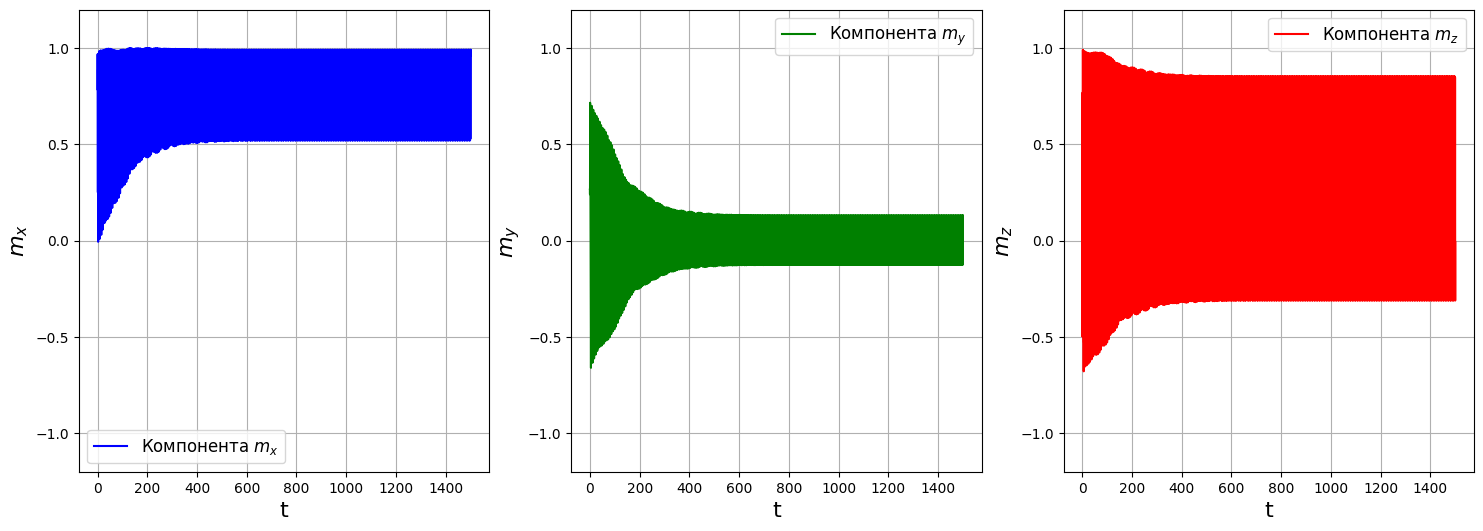

In [85]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.ylim(-1.2, 1.2)
plt.plot(sol_1.t, sol_1.y[0], label='Компонента $m_x $', color='b')
plt.xlabel('t', size=16)
plt.ylabel('$m_{x}$', size=16)
plt.grid(True)  # добавлено для сетки
plt.legend(fontsize=12)

plt.subplot(1, 3, 2)
plt.ylim(-1.2, 1.2)
plt.plot(sol_1.t, sol_1.y[1], label='Компонента $m_y $', color='g')
plt.xlabel('t', size=16)
plt.ylabel('$m_{y}$', size=16)
plt.grid(True)  # добавлено для сетки
plt.legend(fontsize=12)

plt.subplot(1, 3, 3)
plt.ylim(-1.2, 1.2)
plt.plot(sol_1.t, sol_1.y[2], label='Компонента $m_z $', color='r')
plt.xlabel('t', size=16)
plt.ylabel('$m_{z}$', size=16)
plt.grid(True)  # добавлено для сетки
plt.legend(fontsize=12)

plt.show()


In [86]:

def find_max(x_values,y_values):
    # Список для хранения максимумов
    maxima = []
    # Поиск максимумов
    for i in range(1, len(y_values) - 1):
        if y_values[i - 1] < y_values[i] > y_values[i + 1]:
            maxima.append((x_values[i], y_values[i]))
    return maxima


In [87]:

def find_min(x_values,y_values):
    minima = []
    # Поиск минимумов
    for i in range(1, len(y_values) - 1):
        if y_values[i - 1] > y_values[i] < y_values[i + 1]:
            minima.append((x_values[i], y_values[i]))
    return minima        
    


In [92]:
t=0
for i in range (3):
    def show_t_stability (arr_):
        unique_values = []  # Инициализация списка уникальных значений
        for i in range(len(arr_) - 1, -1, -1):  # Итерация с конца массива
            rounded_value = round(arr_[i][1], 2)
            if rounded_value not in unique_values:
                unique_values.append(rounded_value)
                # Если количество уникальных значений больше 2, возвращаем текущий элемент
                if len(unique_values) > 5:
                    return arr_[i][0]
        return None  # Возвращаем None, если условие не выполнено   
    minima = find_min( sol_1.t,sol_1.y[i])
    maxima = find_max( sol_1.t,sol_1.y[i])
    if t< show_t_stability(maxima) or t<show_t_stability(minima):
        if show_t_stability(minima)>show_t_stability(maxima):
            t=show_t_stability(minima)
        else:
            t=show_t_stability(minima)
print (t)

477.53183545569703


In [74]:
show_t_stability(maxima)

np.float64(258.4172278151877)

In [93]:
f = partial(my_sfs, G=G, r=r, alpha=alpha, wF=wF, d=d, V=V, J0=J0)

t_e = np.linspace(t0, tf, nt)
s0 = np.array([mx0, my0, mz0])

# Решение ОДУ
sol_1 = solve_ivp(f, [t0, tf], s0, t_eval=t_e, method='BDF',
                  rtol=1e-8, atol=1e-8)

# Время стабилизации
t_stabilize = t

# Ищем индекс, где время стабилизации заканчивается
idx_stabilize = np.searchsorted(t_e, t_stabilize)

# Извлечение стабилизированных значений
mx_stabilized = sol_1.y[0][idx_stabilize:]
my_stabilized = sol_1.y[1][idx_stabilize:]
mz_stabilized = sol_1.y[2][idx_stabilize:]

# Усреднение
mean_mx = np.mean(mx_stabilized)
mean_my = np.mean(my_stabilized)
mean_mz = np.mean(mz_stabilized)

print(f"Среднее mx после стабилизации: {mean_mx}")
print(f"Среднее my после стабилизации: {mean_my}")
print(f"Среднее mz после стабилизации: {mean_mz}")

Среднее mx после стабилизации: 0.8391881362952202
Среднее my после стабилизации: -0.00040826077874684237
Среднее mz после стабилизации: 0.29621204285792363


In [102]:
Gi = np.linspace(0.1, 10, 5)
print (G)

0.1


In [ ]:
# 1. Создаем массив значений G с равномерно
arr_mean_mx=[]
arr_mean_my=[]
arr_mean_mz=[]
# распределёнными 200-ми точками от 0.1 до 10
for i in range (5):
    G = Gi[i]
    mx0 = 0.7871721023608154
    mz0 = 0.5567178581634524
    my0 = np.sqrt(1-mx0*mx0-mz0*mz0)
    f = partial(my_sfs, G=G, r=r, alpha=alpha, wF=wF, d=d, V=V, J0=J0)
    t_e = np.linspace(t0, tf, nt)
    s0 = np.array([mx0, my0, mz0])
    sol_1 = solve_ivp(f, [t0, tf], s0, t_eval=t_e, method='BDF',
                      rtol=1e-8, atol=1e-8)
    t=0
    for i in range (3):
        minima = find_min( sol_1.t,sol_1.y[i])
        maxima = find_max( sol_1.t,sol_1.y[i])
        if t< show_t_stability(maxima) or t<show_t_stability(minima):
            if show_t_stability(minima)>show_t_stability(maxima):
                t=show_t_stability(minima)
            else:
                t=show_t_stability(minima)
    f = partial(my_sfs, G=G, r=r, alpha=alpha, wF=wF, d=d, V=V, J0=J0)

    t_e = np.linspace(t0, tf, nt)
    s0 = np.array([mx0, my0, mz0])
    
    # Решение ОДУ
    sol_1 = solve_ivp(f, [t0, tf], s0, t_eval=t_e, method='BDF',
                      rtol=1e-8, atol=1e-8)
    
    # Время стабилизации
    t_stabilize = t
    
    # Ищем индекс, где время стабилизации заканчивается
    idx_stabilize = np.searchsorted(t_e, t_stabilize)
    
    # Извлечение стабилизированных значений
    mx_stabilized = sol_1.y[0][idx_stabilize:]
    my_stabilized = sol_1.y[1][idx_stabilize:]
    mz_stabilized = sol_1.y[2][idx_stabilize:]
    
    # Усреднение
    arr_mean_mx.append(np.mean(mx_stabilized))
    arr_mean_my.append( np.mean(my_stabilized))
    arr_mean_mz.append( np.mean(mz_stabilized))
         
        

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(G, arr_mean_mx, label='Mean mx', color='blue')
plt.plot(G, arr_mean_my, label='Mean my', color='green')
plt.plot(G, arr_mean_mz, label='Mean mz', color='red')

# Настройки графика
plt.title('Зависимость средних значений от G')
plt.xlabel('G')
plt.ylabel('Средние значения')
plt.legend()
plt.grid()
plt.show()